# GTHA housing market database
# OSEMN methodology Step 4: Model
# Predict land use from new features in Teranet
# Manually selected features

---

This notebook describes _Step 4: Model_ of OSEMN methodology performed on the Teranet dataset.

## Import dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import os
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from time import time

sns.set()

In [2]:
import sys

sys.path.append('../../src')

from plot_utils import plot_hist
from model_utils import plot_decision_regions

In [3]:
def fit_model(model, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2,
              return_coefs=False):
    
    t = time()
    
    # fit the model
    model.fit(X_train, y_train)
    
    # make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_pred_val1 = model.predict(X_val1)
    y_pred_val2 = model.predict(X_val2)
    
    # score model performance
    train_score = accuracy_score(y_train, y_pred_train)
    test_score = accuracy_score(y_test, y_pred_test)
    val1_score = accuracy_score(y_val1, y_pred_val1)
    val2_score = accuracy_score(y_val2, y_pred_val2)
    
    elapsed = time() - t
    print("\n{0} fit, took {1:,.2f} seconds ({2:,.2f} minutes)".format(model_name, elapsed, elapsed / 60) +
          "\naccuracy: train={0:.2f}, test={1:.2f}, validation #1={2:.2f}, validation #2={3:.2f}"
          .format(train_score, test_score, val1_score, val2_score))
    
    if return_coefs:
        return model.coef_[0]

## Load Teranet data

In [4]:
data_path = '../../data/teranet/'
os.listdir(data_path)

['1.1_Teranet_DA.csv',
 '1.3_Teranet_DA_TAZ_PG_FSA.csv',
 '2_Teranet_consistent.csv',
 'parcel16_epoi13.csv',
 '1.2_Teranet_DA_TAZ.csv',
 '4_Teranet_lu_encode.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU_LUDMTI.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU.csv',
 '.ipynb_checkpoints',
 'ParcelLandUse.zip',
 'ParcelLandUse',
 'HHSaleHistory.csv',
 '3_Teranet_nonan_new_cols.csv',
 'GTAjoinedLanduseSales']

In [5]:
t = time()

df = pd.read_csv(data_path + '4_Teranet_lu_encode.csv',
                 parse_dates=['registration_date'], low_memory=False)
elapsed = time() - t
print("----- DataFrame loaded"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- DataFrame loaded
in 93.19 seconds (1.55 minutes)
with 5,188,513 rows
and 78 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
       'pric

## Take a subset of Teranet records

In [6]:
year = 2011
s = df.query('year == @year')
print("{0:,} records in the subset".format(len(s)))

219,130 records in the subset


## Take validation subsets from Teranet records

In [7]:
year_val1 = 2010
s_val1 = df.query('year == @year_val1')
print("{0:,} records in the subset".format(len(s_val1)))

216,492 records in the subset


In [8]:
year_val2 = 2012
s_val2 = df.query('year == @year_val2')
print("{0:,} records in the subset".format(len(s_val2)))

205,341 records in the subset


## Select features

In [9]:
s.columns

Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
       'price_da_pct_change', 'med_price_xy', 'med_price_year',
       'price_to_med_xy', 'price_to_med_year', 'outlier_

In [10]:
all_feat_cols = ['pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
                 'xy_first_sale', 'pin_years_since_last_sale',
                 'xy_years_since_last_sale', 'xy_years_to_next_sale',
                 'da_days_since_last_sale', 'da_years_since_last_sale',
                 'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
                 'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
                 'price_da_pct_change', 'med_price_xy', 'med_price_year',
                 'price_to_med_xy', 'price_to_med_year', 'outlier_y_3', 'outlier_y_5',
                 'outlier_y_10', 'outlier_y_20', 'outlier_xy_2', 'outlier_xy_4',
                 'outlier_xy_10', 'lucr_house', 'lucr', 'lucr_condo', 'lucr_other']
s = s[all_feat_cols]
s_val1 = s_val1[all_feat_cols]
s_val2 = s_val2[all_feat_cols]
s = s.dropna()
s_val1 = s_val1.dropna()
s_val2 = s_val2.dropna()
print("{0:,} rows in train-test subset, {1:,} rows in validation subset #1, {2:,} rows in validation subset #2"
      .format(len(s), len(s_val1), len(s_val2)))

94,882 rows in train-test subset, 96,283 rows in validation subset #1, 87,085 rows in validation subset #2


## Encode target

In [11]:
le = LabelEncoder()
s['lucr_e'] = le.fit_transform(s['lucr'])
s['lucr_house_e'] = le.fit_transform(s['lucr_house'])
s['lucr_condo_e'] = le.fit_transform(s['lucr_condo'])
s['lucr_other_e'] = le.fit_transform(s['lucr_other'])
s = s.drop(['lucr', 'lucr_house', 'lucr_condo', 'lucr_other'], axis=1)
print("Land use encoded!")
labels = {0: 'condo', 1: 'house', 2: 'other'}
labels_list = ['condo', 'house', 'other']
s['lucr_e'].value_counts().sort_index()

Land use encoded!


0    45454
1    22530
2    26898
Name: lucr_e, dtype: int64

In [12]:
le = LabelEncoder()
s_val1['lucr_e'] = le.fit_transform(s_val1['lucr'])
s_val1['lucr_house_e'] = le.fit_transform(s_val1['lucr_house'])
s_val1['lucr_condo_e'] = le.fit_transform(s_val1['lucr_condo'])
s_val1['lucr_other_e'] = le.fit_transform(s_val1['lucr_other'])
s_val1 = s_val1.drop(['lucr', 'lucr_house', 'lucr_condo', 'lucr_other'], axis=1)
print("Land use encoded!")
s_val1['lucr_e'].value_counts().sort_index()

Land use encoded!


0    45989
1    25736
2    24558
Name: lucr_e, dtype: int64

In [13]:
le = LabelEncoder()
s_val2['lucr_e'] = le.fit_transform(s_val2['lucr'])
s_val2['lucr_house_e'] = le.fit_transform(s_val2['lucr_house'])
s_val2['lucr_condo_e'] = le.fit_transform(s_val2['lucr_condo'])
s_val2['lucr_other_e'] = le.fit_transform(s_val2['lucr_other'])
s_val2 = s_val2.drop(['lucr', 'lucr_house', 'lucr_condo', 'lucr_other'], axis=1)
print("Land use encoded!")
s_val2['lucr_e'].value_counts().sort_index()

Land use encoded!


0    41347
1    18965
2    26773
Name: lucr_e, dtype: int64

In [14]:
labels

{0: 'condo', 1: 'house', 2: 'other'}

## Exploratory Data Analysis (EDA)

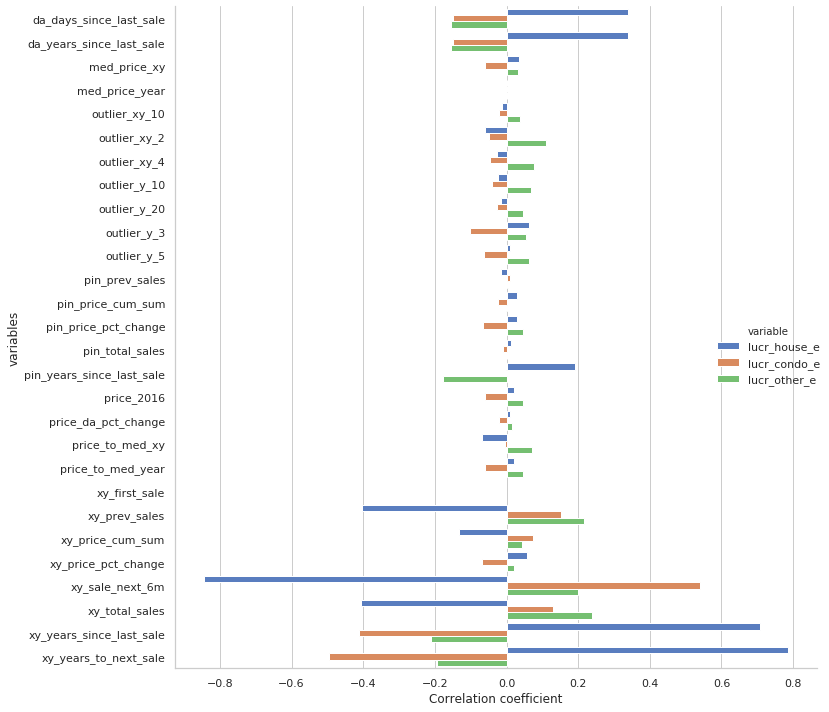

In [15]:
house_corr = s.corr()['lucr_house_e'].reset_index().rename(columns={'index': 'var'})
condo_corr = s.corr()['lucr_condo_e'].reset_index().rename(columns={'index': 'var'})
other_corr = s.corr()['lucr_other_e'].reset_index().rename(columns={'index': 'var'})

targets_corr = pd.merge(pd.merge(house_corr, condo_corr, on='var'), other_corr, on='var')
mask1 = targets_corr['var'].isin(['lucr_e', 'lucr_house_e', 'lucr_condo_e', 'lucr_other_e'])
targets_corr = targets_corr[~mask1]
targets_corr_tidy = pd.melt(targets_corr, id_vars='var').sort_values('var')

# plot correlation coefficients
sns.set_style("whitegrid", {"axes.grid": True})

g = sns.catplot(x="value", y="var", hue="variable", data=targets_corr_tidy,
                kind="bar", palette="muted", height=10, aspect=1)
g.fig.tight_layout()
#g.despine(top=False, left=False)
g.set_ylabels("variables")
g.set_xlabels("Correlation coefficient")
g.savefig("results/plots/all_features_lucr_corr.png", dpi=300)
plt.show()

## Prepare features

#### Select features and target

In [16]:
target_cols = 4
s.columns[:-target_cols]

Index(['pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
       'price_da_pct_change', 'med_price_xy', 'med_price_year',
       'price_to_med_xy', 'price_to_med_year', 'outlier_y_3', 'outlier_y_5',
       'outlier_y_10', 'outlier_y_20', 'outlier_xy_2', 'outlier_xy_4',
       'outlier_xy_10'],
      dtype='object')

In [17]:
X = s.iloc[:, :-target_cols].values
y = s['lucr_e'].values
print("Features and target selected.")

Features and target selected.


In [18]:
X_val1 = s_val1.iloc[:, :-target_cols].values
y_val1 = s_val1['lucr_e'].values
print("Features and target selected.")

Features and target selected.


In [19]:
X_val2 = s_val2.iloc[:, :-target_cols].values
y_val2 = s_val2['lucr_e'].values
print("Features and target selected.")

Features and target selected.


#### Perform train-test split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
print("Performed train-test split.")

Performed train-test split.


In [21]:
len(X_train)

66417

In [22]:
len(y_train)

66417

In [23]:
len(X_test)

28465

In [24]:
len(y_test)

28465

In [25]:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))
print('Labels counts in y_val1:', np.bincount(y_val1))
print('Labels counts in y_val2:', np.bincount(y_val2))

Labels counts in y: [45454 22530 26898]
Labels counts in y_train: [31818 15771 18828]
Labels counts in y_test: [13636  6759  8070]
Labels counts in y_val1: [45989 25736 24558]
Labels counts in y_val2: [41347 18965 26773]


#### Standardize features

In [26]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
print("Input features were standardized.")

Input features were standardized.


In [27]:
X_val1_std = sc.transform(X_val1)
print("Input features were standardized.")

Input features were standardized.


In [28]:
X_val2_std = sc.transform(X_val2)
print("Input features were standardized.")

Input features were standardized.


#### Normalize features

In [29]:
sc = MinMaxScaler()
sc.fit(X_train)
X_train_norm = sc.transform(X_train)
X_test_norm = sc.transform(X_test)
print("Input features were normalized.")

Input features were normalized.


In [30]:
X_val1_norm = sc.transform(X_val1)
print("Input features were normalized.")

Input features were normalized.


In [31]:
X_val2_norm = sc.transform(X_val2)
print("Input features were normalized.")

Input features were normalized.


#### Recombine inputs and targets

In [32]:
X_combined_std = np.vstack((X_train_std, X_test_std))
X_combined_norm = np.vstack((X_train_norm, X_test_norm))
y_combined = np.hstack((y_train, y_test))
print("Input and target recombined.")

Input and target recombined.


### Train and test classification algorithms

#### Perceptron learning algorithm

In [33]:
model_name = 'Perceptron (raw features)'
ppn = Perceptron(max_iter=100, eta0=0.01, random_state=1)
fit_model(ppn, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2)

model_name = 'Perceptron (standardized features)'
ppn = Perceptron(max_iter=100, eta0=0.01, random_state=1)
fit_model(ppn, model_name, X_train_std, y_train, X_test_std, y_test, X_val1_std, y_val1, X_val2_std, y_val2)

model_name = 'Perceptron (normalized features)'
ppn = Perceptron(max_iter=100, eta0=0.01, random_state=1)
fit_model(ppn, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2)


Perceptron (raw features) fit, took 0.98 seconds (0.02 minutes)
accuracy: train=0.62, test=0.62, validation #1=0.64, validation #2=0.60

Perceptron (standardized features) fit, took 0.37 seconds (0.01 minutes)
accuracy: train=0.61, test=0.61, validation #1=0.27, validation #2=0.31

Perceptron (normalized features) fit, took 0.25 seconds (0.00 minutes)
accuracy: train=0.49, test=0.49, validation #1=0.49, validation #2=0.49


#### Logistic regression

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



Logistic regression (raw features) fit, took 3.44 seconds (0.06 minutes)
accuracy: train=0.72, test=0.72, validation #1=0.75, validation #2=0.69


/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



Logistic regression (standardized features) fit, took 1.10 seconds (0.02 minutes)
accuracy: train=0.75, test=0.74, validation #1=0.27, validation #2=0.31


/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



Logistic regression (normalized features) fit, took 1.13 seconds (0.02 minutes)
accuracy: train=0.73, test=0.73, validation #1=0.63, validation #2=0.59


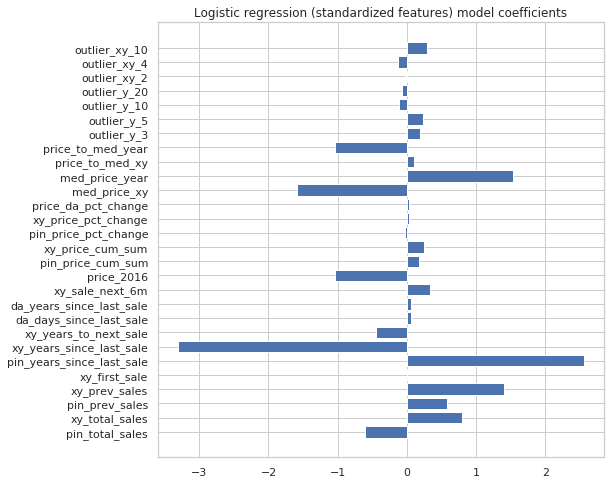

In [34]:
model_name = 'Logistic regression (raw features)'
lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='auto', max_iter=50)
fit_model(lr, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2)

model_name = 'Logistic regression (standardized features)'
lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='auto', max_iter=50)
lr_coef = fit_model(lr, model_name, X_train_std, y_train, X_test_std, y_test, X_val1_std, y_val1, X_val2_std, y_val2,
                    return_coefs=True)

# plot coefficients
plt.figure(figsize=(8, 8))
plt.barh(s.columns[:-target_cols], lr_coef)
plt.title("{0} model coefficients".format(model_name))

model_name = 'Logistic regression (normalized features)'
lr = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='auto', max_iter=50)
fit_model(lr, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_std, y_val1, X_val2_std, y_val2)

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



Logistic regression with L1 regularization, C=1.0 (raw features) fit, took 189.73 seconds (3.16 minutes)
accuracy: train=0.74, test=0.74, validation #1=0.75, validation #2=0.72


/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



Logistic regression with L1 regularization, C=1.0 (standardized features) fit, took 46.13 seconds (0.77 minutes)
accuracy: train=0.74, test=0.74, validation #1=0.27, validation #2=0.47

Logistic regression with L1 regularization, C=1.0 (normalized features) fit, took 7.59 seconds (0.13 minutes)
accuracy: train=0.73, test=0.73, validation #1=0.69, validation #2=0.65


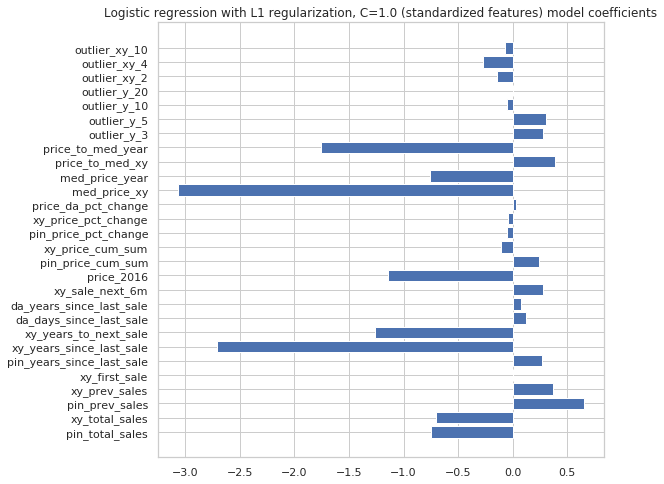

In [39]:
c = 1.0
model_name = 'Logistic regression with L1 regularization, C={0} (raw features)'.format(c)
lr = LogisticRegression(penalty='l1', C=c, random_state=1, solver='liblinear', multi_class='auto', max_iter=50)
fit_model(lr, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2)

model_name = 'Logistic regression with L1 regularization, C={0} (standardized features)'.format(c)
lr = LogisticRegression(penalty='l1', C=c, random_state=1, solver='liblinear', multi_class='auto', max_iter=50)
lr_coef = fit_model(lr, model_name, X_train_std, y_train, X_test_std, y_test, X_val1_std, y_val1, X_val2_std, y_val2,
                    return_coefs=True)

# plot coefficients
plt.figure(figsize=(8, 8))
plt.barh(s.columns[:-target_cols], lr_coef)
plt.title("{0} model coefficients".format(model_name))

model_name = 'Logistic regression with L1 regularization, C={0} (normalized features)'.format(c)
lr = LogisticRegression(penalty='l1', C=c, random_state=1, solver='liblinear', multi_class='auto', max_iter=50)
fit_model(lr, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_std, y_val1, X_val2_std, y_val2)

#### Decision Tree

In [36]:
model_name = 'Decision Tree (raw features)'
tree = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=1)
fit_model(tree, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2)

model_name = 'Decision Tree (standardized features)'
tree = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=1)
fit_model(tree, model_name, X_train_std, y_train, X_test_std, y_test, X_val1_std, y_val1, X_val2_std, y_val2)

model_name = 'Decision Tree (normalized features)'
tree = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=1)
fit_model(tree, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2)


Decision Tree (raw features) fit, took 0.94 seconds (0.02 minutes)
accuracy: train=0.78, test=0.77, validation #1=0.77, validation #2=0.73

Decision Tree (standardized features) fit, took 0.45 seconds (0.01 minutes)
accuracy: train=0.78, test=0.77, validation #1=0.77, validation #2=0.73

Decision Tree (normalized features) fit, took 0.44 seconds (0.01 minutes)
accuracy: train=0.78, test=0.77, validation #1=0.77, validation #2=0.73


#### Random Forest

In [37]:
model_name = 'Random Forest (raw features)'
forest = RandomForestClassifier(criterion='gini', n_estimators=25, random_state=1, n_jobs=8)
fit_model(forest, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2)

model_name = 'Random Forest (standardized features)'
forest = RandomForestClassifier(criterion='gini', n_estimators=25, random_state=1, n_jobs=8)
fit_model(forest, model_name, X_train_std, y_train, X_test_std, y_test, X_val1_std, y_val1, X_val2_std, y_val2)

model_name = 'Random Forest (normalized features)'
forest = RandomForestClassifier(criterion='gini', n_estimators=25, random_state=1, n_jobs=8)
fit_model(forest, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2)


Random Forest (raw features) fit, took 2.58 seconds (0.04 minutes)
accuracy: train=1.00, test=0.95, validation #1=0.88, validation #2=0.87

Random Forest (standardized features) fit, took 2.03 seconds (0.03 minutes)
accuracy: train=1.00, test=0.95, validation #1=0.88, validation #2=0.87

Random Forest (normalized features) fit, took 2.02 seconds (0.03 minutes)
accuracy: train=1.00, test=0.95, validation #1=0.89, validation #2=0.86


#### K-nearest neighbors

In [38]:
model_name = 'K-nearest neighbors (raw features)'
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
fit_model(knn, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2)

model_name = 'K-nearest neighbors (standardized features)'
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
fit_model(knn, model_name, X_train_std, y_train, X_test_std, y_test, X_val1_std, y_val1, X_val2_std, y_val2)

model_name = 'K-nearest neighbors (normalized features)'
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
fit_model(knn, model_name, X_train_norm, y_train, X_test_norm, y_test, X_val1_norm, y_val1, X_val2_norm, y_val2)


K-nearest neighbors (raw features) fit, took 23.29 seconds (0.39 minutes)
accuracy: train=0.83, test=0.75, validation #1=0.71, validation #2=0.68

K-nearest neighbors (standardized features) fit, took 1,969.26 seconds (32.82 minutes)
accuracy: train=0.92, test=0.87, validation #1=0.26, validation #2=0.31

K-nearest neighbors (normalized features) fit, took 180.69 seconds (3.01 minutes)
accuracy: train=0.92, test=0.88, validation #1=0.78, validation #2=0.75
